In [1]:
import numpy as np
import pandas as pd
import os
import time
import pickle
import gzip

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os

os.chdir("/content/drive/MyDrive/Data/Assignment/[0207]_Dimensionality Reduction")

In [ ]:
from tqdm import tqdm_notebook

ram = []

for i in tqdm_notebook(range(1000000)) :

  ram.append('RAM 터트리기'*i)

<ipython-input-4-23bf699542b1>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(1000000)) :


  0%|          | 0/1000000 [00:00<?, ?it/s]

# Fashion MNIST dataset
- 28*28 pixels(784 차원)
- label
  - 0 T-shirt/top
  - 1 Trouser
  - 2 Pullover
  - 3 Dress
  - 4 Coat
  - 5 Sandal
  - 6 Shirt
  - 7 Sneaker
  - 8 Bag
  - 9 Ankle boot


In [6]:
#데이터 불러오기
fashion = pd.read_csv('fashion-mnist.csv')
 
fashion.head(3) #60000 rows

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0


- (Q1) X_train, y_train, X_test, y_test 지정하기
  - 60000개의 전체 데이터셋 사용하지 않아도 됨 (학습 속도가 느려짐)
  - 본인이 생각하는 적절한 train 개수, test 개수를 설정하여 분리하도록
    - 이때 train과 test 데이터의 라벨 분포가 균등하게 이루어지도록 분리해야함(학습시에 편향되지 않도록)
    - 그래프 그려서 라벨값 분포가 균등한지 확인할 것

In [7]:
X_features = fashion.iloc[:,1:]
y_label = fashion['label']

X_train , X_test, y_train, y_test = train_test_split(X_features, y_label, train_size = 0.75, test_size = 0.25 , random_state = 1)

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(45000, 784) (45000,) (15000, 784) (15000,)


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


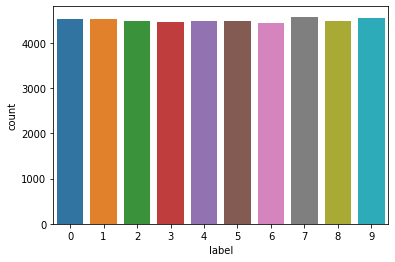

In [ ]:
sns.countplot(y_train)

plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


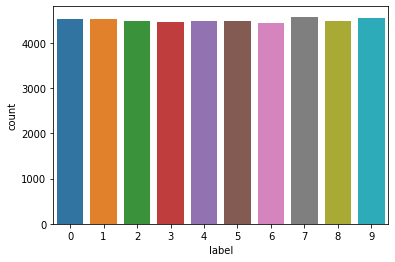

In [ ]:
sns.countplot(y_train)

plt.show()

- 어떻게 생긴 데이터셋인지 확인해보기

In [ ]:
y_label.unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1])

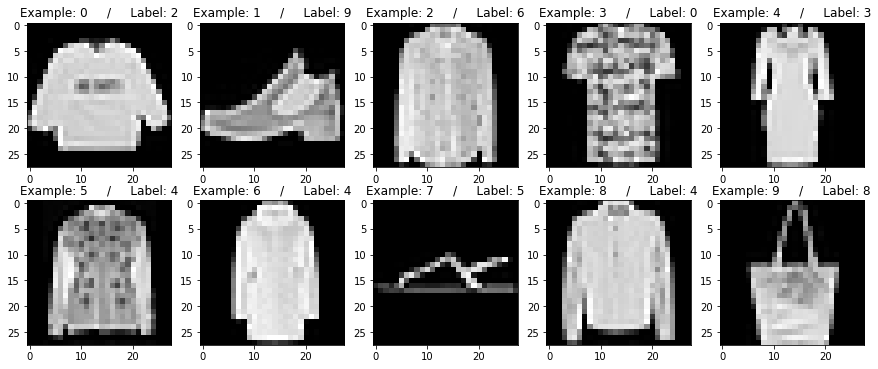

In [ ]:
plt.figure(figsize=(15,6))

for i in range(0,10) :

  plt.subplot(2,5,i+1)
  label = y_train.loc[i]
  image = X_train.loc[i,:].values.reshape([28, 28])

  plt.imshow(image, cmap=plt.get_cmap('gray'))
  plt.title('Example: %d     /     Label: %d'%(i, label))

plt.show()

# PCA를 활용해 성능 높여보기


- (Q2) 합리적인 잠재변수 개수 설정하기
  - PCA에서 각 잠재변수가 설명하는 분산 비율을 보고 적절한 잠재변수 개수 설정
  - 개수 설정 기준은 본인 재량. 다만, 명확한 기준을 서술할 것.

In [ ]:
from sklearn.decomposition import PCA

# original space(784차원)을 그대로 대입했을때 분류 성능, 학습 속도 측정해보기
pca = PCA(n_components = 784)

X_train_PCA = pca.fit_transform(X_train)

X_train_PCA.shape

(45000, 784)

In [ ]:
pca.explained_variance_ratio_[:10]

array([0.28974762, 0.17743385, 0.06020052, 0.04987182, 0.03803632,
       0.03467089, 0.023479  , 0.01929564, 0.01345444, 0.01314671])

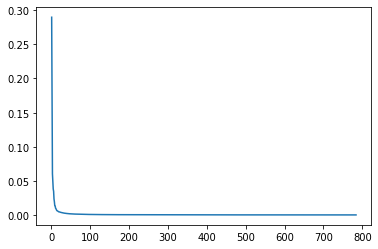

In [ ]:
plt.plot(range(1,785),pca.explained_variance_ratio_)

plt.show()

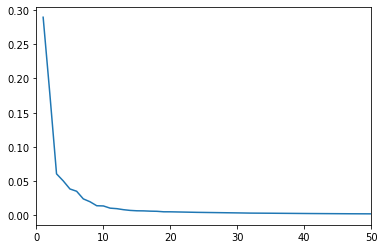

In [ ]:
plt.plot(range(1,785),pca.explained_variance_ratio_)

plt.xlim(0,50)
plt.show()

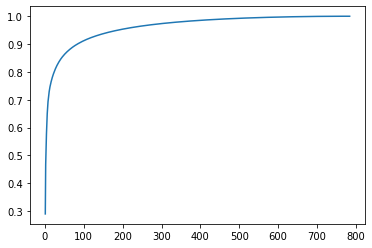

In [ ]:
cumulative = []
temp = 0

for i in range(0, 784) :
  
    temp += pca.explained_variance_ratio_[i]
    cumulative.append(temp)

plt.plot(range(1,785),cumulative)
plt.show()

In [ ]:
for i in [10,20,50,100,784] :

  explained=np.sum(pca.explained_variance_ratio_[:i])
  
  print(i,'개의 잠재변수가 설명하는 분산은 전체 데이터의 {:.2f}%'.format(explained*100))

10 개의 잠재변수가 설명하는 분산은 전체 데이터의 71.93%
20 개의 잠재변수가 설명하는 분산은 전체 데이터의 78.46%
50 개의 잠재변수가 설명하는 분산은 전체 데이터의 86.24%
100 개의 잠재변수가 설명하는 분산은 전체 데이터의 91.21%
784 개의 잠재변수가 설명하는 분산은 전체 데이터의 100.00%


In [ ]:
cumulative = np.array(cumulative)

np.where(cumulative>0.8)[0][0] 

23

In [ ]:
# 23개의 잠재변수가 설명하는 분산은 전체 데이터의 80% 이상이므로 잠재변수는 23개만 사용
pca = PCA(n_components = 23)

X_train_PCA = pca.fit_transform(X_train) # train은 fit + transform
X_test_PCA = pca.transform(X_test)       # test는 transform

print('Original space:',X_train.shape)
print('After PCA:',X_train_PCA.shape)

Original space: (45000, 784)
After PCA: (45000, 23)


- (Q3) 학습속도, 성능의 향상을 보이는지 확인
  - 기존에 배웠던 여러가지 classification model들 활용하기
  - 최소한 1가지 이상의 모델에 대해 비교해보고 차원축소 이전, 이후 어떠한 차이를 보이는지 서술


## 1) Logistic Regression

In [ ]:
#차원축소 이전(origianl 공간 784차원)
start = time.time()
logistic_original = LogisticRegression(max_iter = 1000) # warning 메시지가 나와서 max_iter 지정해줌
logistic_original.fit(X_train, y_train)  # train set만 고려

print('train accuracy:',accuracy_score(y_train, logistic_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, logistic_original.predict(X_test)))
print("소요 시간 : ", f'{time.time()-start:.4f}sec')

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


train accuracy: 0.8859777777777778
test accuracy: 0.8364666666666667
소요 시간 :  364.4973sec


In [ ]:
#차원축소 이후(42차원)
start = time.time()
logistic_pca = LogisticRegression(max_iter=1000) 
logistic_pca.fit(X_train_PCA, y_train)

print('train accuracy:',accuracy_score(y_train, logistic_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, logistic_pca.predict(X_test_PCA)))
print('차원축소 후 소요시간 : ' , f'{time.time()-start:.4f}sec')

train accuracy: 0.8128
test accuracy: 0.8078666666666666
차원축소 후 소요시간 :  57.0853sec


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 2) Decision Tree

In [ ]:
#차원축소 이전(origianl 공간 784차원)
start = time.time()
DecisionTree_original = DecisionTreeClassifier() # warning 메시지가 나와서 max_iter 지정해줌
DecisionTree_original.fit(X_train, y_train)  # train set만 고려

print('train accuracy:',accuracy_score(y_train, DecisionTree_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, DecisionTree_original.predict(X_test)))
print("소요 시간 : ", f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.7906666666666666
소요 시간 :  36.8770sec


In [ ]:
#차원축소 이후(42차원)
start = time.time()
DecisionTree_pca = DecisionTreeClassifier() 
DecisionTree_pca.fit(X_train_PCA, y_train)

print('train accuracy:',accuracy_score(y_train, DecisionTree_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, DecisionTree_pca.predict(X_test_PCA)))
print('차원축소 후 소요시간 : ' , f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.7710666666666667
차원축소 후 소요시간 :  3.1601sec


## 3) RandomForest

In [ ]:
#차원축소 이전(784차원)
start = time.time()
rf_original=RandomForestClassifier()
rf_original.fit(X_train,y_train)
print('train accuracy:',accuracy_score(y_train, rf_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, rf_original.predict(X_test)))
print('소요 시간 : ' , f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.8767333333333334
소요 시간 :  86.4423sec


In [ ]:
#차원축소 이후(42차원)
start = time.time()
rf_pca = RandomForestClassifier()
rf_pca.fit(X_train_PCA, y_train)
print('train accuracy:',accuracy_score(y_train, rf_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, rf_pca.predict(X_test_PCA)))
print('차원축소 후 소요시간 : ' , f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.8546
차원축소 후 소요시간 :  33.0303sec


## 4) XGBoost

In [ ]:
#차원축소 이전
start = time.time()
xgboost_original = XGBClassifier()
xgboost_original.fit(X_train, y_train)

print('train accuracy:',accuracy_score(y_train, xgboost_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, xgboost_original.predict(X_test)))
print('소요 시간 : ' , f'{time.time()-start:.4f}sec')

train accuracy: 0.8829777777777778
test accuracy: 0.8602
소요 시간 :  1083.8266sec


In [ ]:
#차원축소 이후
start = time.time()
xgboost_pca = XGBClassifier()
xgboost_pca.fit(X_train_PCA, y_train)

print('train accuracy:',accuracy_score(y_train, xgboost_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, xgboost_pca.predict(X_test_PCA)))
print('차원축소 후 소요시간 : ' , f'{time.time()-start:.4f}sec')

train accuracy: 0.8403555555555555
test accuracy: 0.8186
차원축소 후 소요시간 :  88.6568sec


## 5) LightGBM

In [ ]:
#차원축소 이전(784차원)
start = time.time()
LGBM_original=LGBMClassifier()
LGBM_original.fit(X_train,y_train)

print('train accuracy:',accuracy_score(y_train, LGBM_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, LGBM_original.predict(X_test)))
print('소요 시간 : ' , f'{time.time()-start:.4f}sec')

train accuracy: 0.9741333333333333
test accuracy: 0.8921333333333333
소요 시간 :  427.2964sec


In [ ]:
#차원축소 이후(42차원)
start = time.time()
LGBM_pca = LGBMClassifier()
LGBM_pca.fit(X_train_PCA, y_train)

print('train accuracy:',accuracy_score(y_train, LGBM_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, LGBM_pca.predict(X_test_PCA)))
print('차원축소 후 소요시간 : ' , f'{time.time()-start:.4f}sec')

train accuracy: 0.9258444444444445
test accuracy: 0.8569333333333333
차원축소 후 소요시간 :  20.5036sec


# 2차원으로 시각화
- (Q4) 여러가지 차원 축소 방법 중 적절할 것으로 예상되는 방법 최소한 3가지 이용해서 시각화해보기
  - 하나의 차원 축소 방법도 하이퍼파라미터의 설정 다양하게 해보기
  - ex) KPCA에서 다양한 커널 함수 사용, ISOMAP or LLE에서 고려할 이웃의 개수 변경해보기

> 사용 가능한 RAM을 모두 사용한 후 세션이 다운되어 2개까지 밖에 못함.

## 1) PCA
- 분산을 크게하는 잠재변수를 찾자

In [ ]:
start = time.time()
pca = PCA(n_components=2)
X_train_PCA = pca.fit_transform(X_train) 

print('소요시간 : ' , f'{time.time()-start:.4f}sec')

소요시간 :  4.1160sec


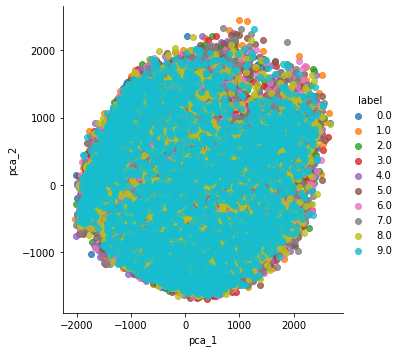

In [ ]:
X_train_pca = pd.DataFrame(X_train_PCA).loc[:,0:1]
X_train_pca = pd.concat((X_train_pca, y_train), axis=1) 
X_train_pca.columns=['pca_1', 'pca_2', 'label']

sns.lmplot(x = 'pca_1', y = 'pca_2' , data = X_train_pca , hue = 'label' , fit_reg = False)

plt.show()

## 2) LDA
- class(label)을 잘 구분해주는 축을 찾자

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

start = time.time()
lda = LinearDiscriminantAnalysis(n_components = 2)
X_train_lda = lda.fit_transform(X_train, y_train) #차원축소 과정에 y라벨값을 입력해줌

print('소요시간 : ' , f'{time.time()-start:.4f}sec')

소요시간 :  15.8332sec


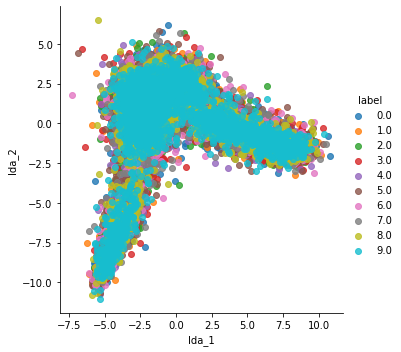

In [ ]:
X_train_lda = pd.DataFrame(X_train_lda).loc[:,0:1]
X_train_lda = pd.concat((X_train_lda, y_train), axis=1) 
X_train_lda.columns=['lda_1' , 'lda_2' , 'label']
X_train_lda

sns.lmplot(x = 'lda_1' , y = 'lda_2' , data = X_train_lda , hue = 'label' , fit_reg = False)
plt.show()

## 3) KPCA
- 고차원에서 분산을 크게 해주는 축을 찾자
- 데이터의 형태에 따라 적절한 커널 및 하이퍼파라미터을 사용해줄 필요 있음.

In [ ]:
from sklearn.decomposition import KernelPCA

start = time.time()
rbf_pca = KernelPCA(n_components = 2 , kernel = "rbf" , gamma = 0.0433 , fit_inverse_transform = True) #방사형 커널 사용
X_train_rbf_pca = rbf_pca.fit_transform(X_train)

print('소요시간 : ' , f'{time.time()-start:.4f}sec')

In [ ]:
start=time.time()

sig_pca = KernelPCA(n_components = 2 , kernel = "sigmoid" , gamma = 0.001 , coef0 = 1 , fit_inverse_transform = True) #시그모이드 커널 사용
X_train_sig_pca = sig_pca.fit_transform(X_train)
#X_test_rbf_pca=sig_pca.fit_transform(X_test)

print('소요시간 : ',f'{time.time()-start:.4f}sec')

7.7767sec


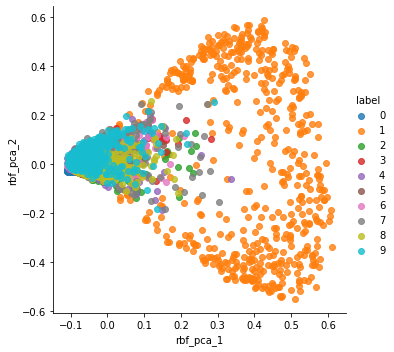

In [ ]:
X_train_rbf_pca = pd.DataFrame(X_train_rbf_pca).loc[:,0:1]
X_train_rbf_pca = pd.concat((X_train_rbf_pca, y_train), axis=1) 
X_train_rbf_pca.columns=['rbf_pca_1', 'rbf_pca_2', 'label']

sns.lmplot(x = 'rbf_pca_1', y = 'rbf_pca_2' , data = X_train_rbf_pca , hue = 'label' , fit_reg = False)

plt.show()

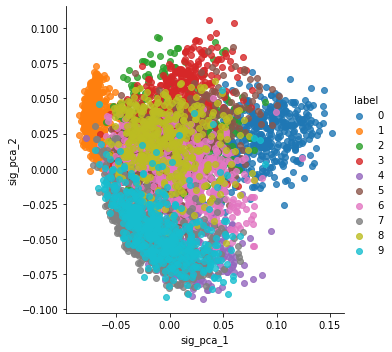

In [ ]:
X_train_sig_pca = pd.DataFrame(X_train_sig_pca).loc[:,0:1]
X_train_sig_pca = pd.concat((X_train_sig_pca, y_train), axis=1) 
X_train_sig_pca.columns=['sig_pca_1', 'sig_pca_2', 'label']

sns.lmplot(x = 'sig_pca_1' , y = 'sig_pca_2' , data = X_train_sig_pca , hue = 'label' , fit_reg = False)

plt.show()

## 4) ISOMAP
- 지오데식 거리를 최대한 보존하는 저차원의 공간을 찾자

In [ ]:
from sklearn.manifold import Isomap

# n_neighbors = 5
start = time.time()
isomap_5 = Isomap(n_neighbors = 5 , n_components = 2 , n_jobs = 4)         
X_train_isomap_5 = isomap_5.fit_transform(X_train)

print('소요시간 : ' , f'{time.time()-start:.4f}sec')

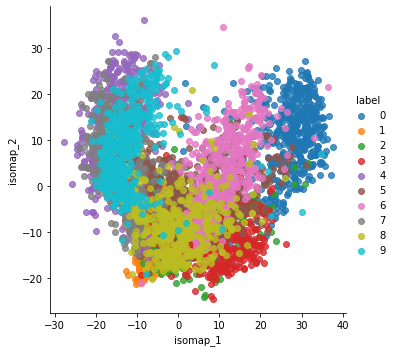

In [ ]:
X_train_isomap_5 = pd.DataFrame(X_train_isomap_5).loc[:,0:1]
X_train_isomap_5 = pd.concat((X_train_isomap_5, y_train), axis=1) 
X_train_isomap_5.columns=['isomap_1', 'isomap_2', 'label']

sns.lmplot(x ='isomap_1' , y = 'isomap_2' , data = X_train_isomap_5 , hue = 'label' , fit_reg = False)
plt.show()

In [ ]:
# n_neighbors = 7
start = time.time()
isomap_7 = Isomap(n_neighbors = 7 , n_components = 2 , n_jobs = 4)         
X_train_isomap_7 = isomap_7.fit_transform(X_train)

print('소요시간 : ' , f'{time.time()-start:.4f}sec')

27.1176sec


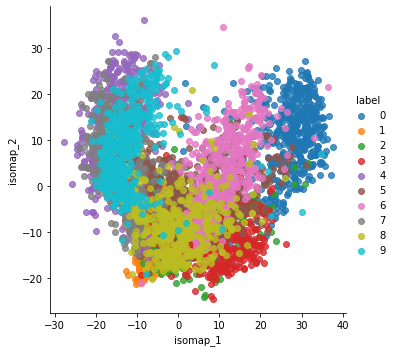

In [ ]:
X_train_isomap_7 = pd.DataFrame(X_train_isomap_7).loc[:,0:1]
X_train_isomap_7 = pd.concat((X_train_isomap_7, y_train), axis=1) 
X_train_isomap_7.columns=['isomap_1', 'isomap_2', 'label']

sns.lmplot(x ='isomap_1' , y = 'isomap_2' , data = X_train_isomap_7 , hue = 'label' , fit_reg = False)
plt.show()

## 5) LLE
- 주변 이웃들의 관계를 저차원에서도 그대로 유지하는 저차원 공간을 찾자

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

start = time.time()
lle = LocallyLinearEmbedding(n_components = 2, random_state = 42)
X_train_lle = lle.fit_transform(X_train)
#X_test_lle=lle.transform(X_test)

print('소요시간 : ',f'{time.time()-start:.4f}sec')

4.0752sec


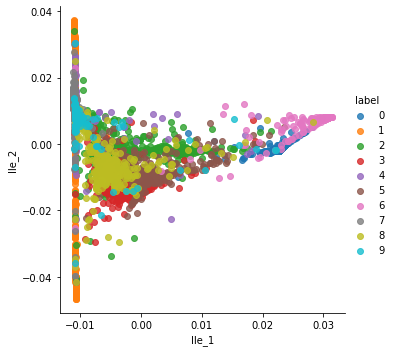

In [ ]:
X_train_lle = pd.DataFrame(X_train_lle).loc[:,0:1]
X_train_lle = pd.concat((X_train_lle, y_train), axis=1) 
X_train_lle.columns=['lle_1', 'lle_2', 'label']
X_train_lle

sns.lmplot(x = 'lle_1' , y = 'lle_2' , data = X_train_lle , hue = 'label' , fit_reg = False)
plt.show()

## 6) t-SNE
- 주변 이웃들과의 확률적 관계를 그대로 유지해주는 저차원의 공간을 찾자

In [ ]:
from sklearn.manifold import TSNE

start=time.time()
tsne = TSNE(n_components = 2 , random_state = 42) #4미만의 공간으로
X_train_tsne = tsne.fit_transform(X_train)

print('소요시간 : ',f'{time.time()-start:.4f}sec')

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


77.4994sec


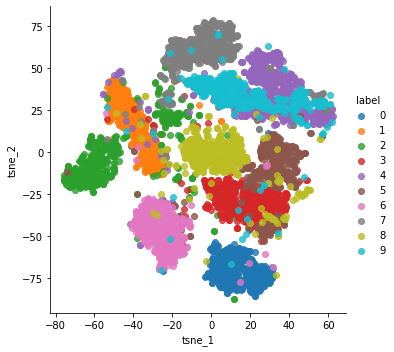

In [ ]:
X_train_tsne = pd.DataFrame(X_train_tsne).loc[:,0:1]
X_train_tsne = pd.concat((X_train_tsne, y_train), axis=1) 
X_train_tsne.columns=['tsne_1', 'tsne_2', 'label']
X_train_tsne

sns.lmplot(x = 'tsne_1' , y = 'tsne_2' , data = X_train_tsne , hue = 'label' , fit_reg = False)
plt.show()

- (Q5) 시도해본 차원축소 방법 중 Fashion MNIST 데이터셋을 가장 잘 시각화하는 것으로 보이는 방법은 무엇인지 서술해보자.

- (Q6) 저차원에서 제대로 분류가 잘 되지 않는 라벨은 무엇인지 언급해보고, 왜 제대로 분류되지 않을 것인지 추측해보자.

수고하셨습니다~